1. Ler imagem
2. Tecnica de compresão
3. Calculo de tx de compressao e SNRF
4. Salvar imagem no disco
5. Descomprimir imagem

In [30]:
import io
import os
import numpy as np
import cv2 as cv
from scipy import fftpack
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
def img_dct(img):
    return fftpack.dct(fftpack.dct(img.T,norm='ortho').T, norm='ortho')

def img_idct(coef):
    return fftpack.idct(fftpack.idct(coef.T, norm='ortho').T, norm='ortho')

def rmse(pred, target):
    return np.sqrt(((pred-target) ** 2).mean())

def psnr(pred, target):
    rmsev = rmse(pred, target)
    return 20 * np.log10(255/rmsev)

'\n#sub 128 \nfor i in range(num_parts): tiles[i] = tiles[i]-128\nfor i in range(num_parts): tiles[i] = (np.float32(tiles[i])/255.0)\n#calculo DCT\nfor i in range(num_parts): tiles[i] = cv.dct(tiles[i])\n#quantizacao\nfor i in range(num_parts): tiles[i] = tiles[i]/quant\nfor i in range(num_parts): tiles[i] = (np.float32(tiles[i])*255.0)\nfor i in range(num_parts):\n    for j in range(8):\n        for k in range(8):\n            tiles[i][j][k] = round(tiles[i][j][k],0)\n\nprint(img_in.size)'

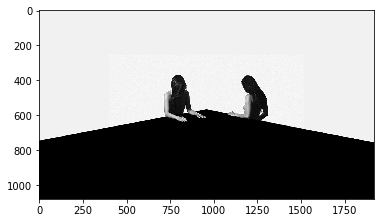

In [39]:
#Image Read
img_in = cv.imread('HowDidWeGetSoDark.jpg',0)
img_in = img_in.astype(float)
img_in = img_in-128
tam_bloco = 8

lin, col = np.shape(img_in)

num_parts = int((lin/tam_bloco)*(lin/tam_bloco))
IDCT = img_cmp = np.zeros((lin,col),dtype=float)
DCT = img_cmp = np.zeros((lin,col),dtype=float)

#matriz de quantização
quant = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 7],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]])
quant = quant.astype(float)


#Sub divisão em blocos de 8x8
tiles = [img_in[x:x+8,y:y+8] for x in range(0,img_in.shape[0],8) for y in range(0,img_in.shape[1],8)]

for i in range(0,lin,tam_bloco):
    for j in range(0,col,tam_bloco):
        dct = img_dct(img_in[i:i+tam_bloco, j:j+tam_bloco])
        idct = img_idct(dct)
        IDCT[i:i+tam_bloco, j:j+tam_bloco] = idct
        DCT[i:i+tam_bloco, j:j+tam_bloco] = dct

img_in = img_in+128
IDCT = IDCT+128

plt.imshow(img_in,cmap='gray')

cv.imwrite("dct.png",DCT)
cv.imwrite("idct.png",IDCT)

"""
#sub 128 
for i in range(num_parts): tiles[i] = tiles[i]-128
for i in range(num_parts): tiles[i] = (np.float32(tiles[i])/255.0)
#calculo DCT
for i in range(num_parts): tiles[i] = cv.dct(tiles[i])
#quantizacao
for i in range(num_parts): tiles[i] = tiles[i]/quant
for i in range(num_parts): tiles[i] = (np.float32(tiles[i])*255.0)
for i in range(num_parts):
    for j in range(8):
        for k in range(8):
            tiles[i][j][k] = round(tiles[i][j][k],0)

print(img_in.size)"""
#plt.imshow(img1,cmap='gray')

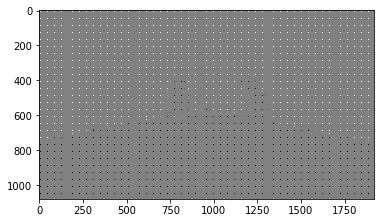

In [35]:
plt.imshow(DCT,cmap='gray')

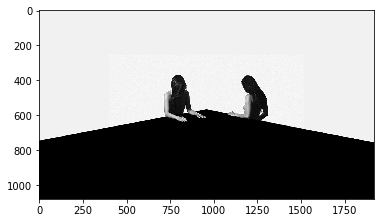

In [36]:
plt.imshow(IDCT,cmap='gray')

RMSE: 1.399
PSNR: 45.216


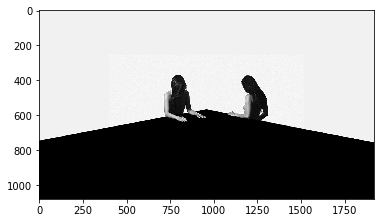

In [41]:
#Compressão usando matriz de quantização

img_in = img_in-128

useDC = True

for i in range(0,lin,tam_bloco):
    for j in range(0,col,tam_bloco):
        dct = img_dct(img_in[i:i+tam_bloco, j:j+tam_bloco])
        odct = dct
        DC = dct[0,0]
        
        dct = np.divide(dct, quant)
        dct = dct.round()
        coddct = dct
        
        dct = np.multiply(dct, quant)
        if(useDC == True):
            dct[0,0] = DC
        IDCT[i:i+tam_bloco, j:j+tam_bloco] = img_idct(dct)
        
IDCT = IDCT+128
img_in = img_in+128

print ("RMSE: %5.3f" % rmse(img_in, IDCT))
print ("PSNR: %5.3f" % psnr(img_in, IDCT))

plt.imshow(img_in,cmap='gray')

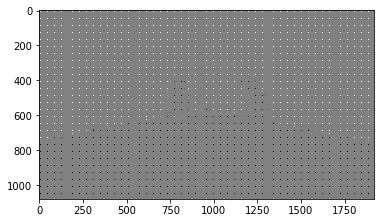

In [42]:
plt.imshow(DCT,cmap='gray')

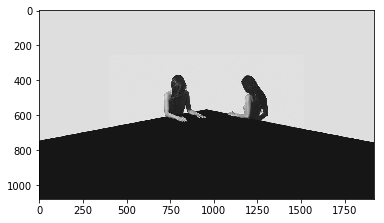

In [43]:
plt.imshow(IDCT,cmap='gray')